In [55]:
%matplotlib inline

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
from pprint import pprint

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

PLOT_COLORS = {'vector': 'black', 'hybrid': 'darkorange', 'hybrid (weighted)': 'green'}
PLOT_LABEL = {'vector': 'vector', 'hybrid': 'hybrid', 'hybrid (weighted)': 'hybrid (weighted)'}

def select_color(s):
    if "vector" in s.lower():
        return PLOT_COLORS['vector']
    elif "hybrid" in s.lower():
        if "weighted" in s.lower():
            return PLOT_COLORS['hybrid (weighted)']
        else:
            return PLOT_COLORS['hybrid']

def select_plot_label(s):
    if "vector" in s.lower():
        return PLOT_LABEL['vector']
    elif "hybrid" in s.lower():
        if "weighted" in s.lower():
            return PLOT_LABEL['hybrid (weighted)']
        else:
            return PLOT_LABEL['hybrid']

In [56]:
np.mean([])

/data/zyang/miniconda3/envs/pt/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/zyang/miniconda3/envs/pt/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [57]:
def get_sort_resdir_by_name(res_root, append_n="stats_cos.res"):
    '''
    this function parse the res_dir by name, and sort it by k and gk
    '''
    res_dirs = os.listdir(res_root)
    k_gk_dict = {}
    for rd in res_dirs:
        k = int(rd.split('_')[0][1:])
        gk = int(rd.split('_')[1][2:])
        full_path = os.path.join(res_root, rd, append_n)
        if k not in k_gk_dict:
            k_gk_dict[k] = {gk: full_path}
        else:
            k_gk_dict[k][gk] = full_path
        # sort dict by key
        k_gk_dict = dict(sorted(k_gk_dict.items()))
        for k, v in k_gk_dict.items():
            k_gk_dict[k] = dict(sorted(v.items()))
    return k_gk_dict

def preprocess_df(df):
    # parse prob and cv from filename
    cv_list = []
    abs_prob_list = []
    for index, row in df.iterrows():
        prob = float(row['filename'].split('prob')[-1][:3].replace('_', '.'))
        abs_prob_list.append(prob)
        cv = float(row['filename'].split('_num')[0].split('cv')[-1].replace('_', '.'))
        cv_list.append(cv)
    df['prob'] = abs_prob_list
    df['cv'] = cv_list
    return df

In [58]:
df = pd.read_csv("/data/zyang/beyond_vector_search/data/results/k1000_gk100_outputs/stats_cos.res")
# pd.set_option("display.max_rows", None)
# mean_columns = [col for col in df.columns if "mean" in col or "filename" in col]
# df_mean = df[mean_columns]

df = preprocess_df(df)

cvs = np.unique(df['cv'])

df.head()

,filename,distances_arxiv_vector_mean,distances_arxiv_vector_std,distances_arxiv_vector_max,distances_arxiv_vector_min,distances_hybrid_mean,distances_hybrid_std,distances_hybrid_max,distances_hybrid_min,distances_weighted_hybrid_mean,...,percent_include_hybrid_mean,percent_include_hybrid_std,percent_include_hybrid_max,percent_include_hybrid_min,percent_include_weighted_hybrid_mean,percent_include_weighted_hybrid_std,percent_include_weighted_hybrid_max,percent_include_weighted_hybrid_min,prob,cv
0,k1000_gk100_cv0_05_num20_prob0_1.csv,0.865934,0.064185,0.988919,0.663777,0.869022,0.060760,0.986162,0.662009,0.860441,...,0.200553,0.154837,0.692,0.007,0.208118,0.160193,0.712,0.008,0.1,0.05
1,k1000_gk100_cv0_05_num20_prob0_3.csv,0.850259,0.071247,0.991433,0.631818,0.850931,0.069859,0.988361,0.633410,0.844776,...,0.242448,0.167087,0.668,0.006,0.251957,0.173092,0.682,0.006,0.3,0.05
2,k1000_gk100_cv0_05_num20_prob0_5.csv,0.847027,0.067067,0.986692,0.653176,0.849510,0.065014,0.986871,0.654192,0.841936,...,0.271545,0.166602,0.694,0.011,0.281005,0.172945,0.716,0.008,0.5,0.05
3,k1000_gk100_cv0_05_num20_prob1_0.csv,0.813066,0.068037,0.982944,0.643972,NaN,NaN,NaN,NaN,0.807993,...,0.362059,0.136535,0.682,0.006,0.372612,0.141873,0.710,0.012,1.0,0.05
4,k1000_gk100_cv0_1_num10_prob0_1.csv,0.866864,0.060758,0.986911,0.647734,0.868680,0.058438,0.984093,0.650229,0.861519,...,0.199407,0.143663,0.671,0.007,0.208075,0.149507,0.701,0.007,0.1,0.10


In [59]:
def get_methods_metrcs(stats_row_dict, metric='accuracy', method_names=['arxiv_vector', 'hybrid', 'weighted_hybrid']):
    res_dict = {}
    res_std_dict = {}
    mean_keys = ["{}_{}_mean".format(metric, name) for name in method_names]
    std_keys = ["{}_{}_std".format(metric, name) for name in method_names]
    for i in range(len(mean_keys)):
        res_dict[mean_keys[i]] = stats_row_dict[mean_keys[i]]
        res_std_dict[std_keys[i]] = stats_row_dict[std_keys[i]]
    return res_dict, res_std_dict

def merge_metric_dict(md1, md2):
    # md1: {acc: x1} OR {acc: [x1, x2]}
    # md2: {acc: x3}
    # return {acc: [x1, x2]} OR {acc: [x1, x2, x3]}
    res = {}
    for k, v1 in md1.items():
        # if v1 is not a list, convert it to a list
        if not isinstance(v1, list):
            v1 = [v1]
        # check v2 from md2
        v2 = md2[k]
        if not isinstance(v2, list):
            v2 = [v2]
        res[k] = v1 + v2
    return res

In [60]:
# md1, _ = get_methods_metrcs(df.iloc[0])
# md2, _ = get_methods_metrcs(df.iloc[0])
# merge_metric_dict(md1, md2)

In [61]:
def parse_df_cv(df, metric='accuracy'):
    mean_2dlist = {}
    std_2dlist = {}
    cvs = np.unique(df['cv'])
    for cv in cvs:
        df_cv = df[df['cv'] == cv]
        mergre_metric_dict = {}
        mergre_metric_std_dict = {}
        for index, row in df_cv.iterrows():
            stats_row_dict, stats_row_std_dict = get_methods_metrcs(row.to_dict(), metric=metric)
            if not mergre_metric_dict:
                mergre_metric_dict = stats_row_dict
            else:
                mergre_metric_dict = merge_metric_dict(mergre_metric_dict, stats_row_dict)
            
            if not mergre_metric_std_dict:
                mergre_metric_std_dict = stats_row_std_dict
            else:
                mergre_metric_std_dict = merge_metric_dict(mergre_metric_std_dict, stats_row_std_dict)

        mean_2dlist[cv] = mergre_metric_dict
        std_2dlist[cv] = mergre_metric_std_dict
    return mean_2dlist, std_2dlist

def get_plot_data(mean_2dlist, std_2dlist):
    plot_data = {} # method: {mean, std}
    for x in sorted(list(mean_2dlist.keys())):
        # loop through each method
        for k, v in mean_2dlist[x].items():
            mean_data = []
            std_data = []
            max_data = []
            min_data = []
            mean_data.append(np.mean(v))
            max_data.append(np.max(v))
            min_data.append(np.min(v))

            std_key = k.replace("mean", "std")
            std_data.append(np.mean(std_2dlist[x][std_key]))
            
            if k not in plot_data:
                plot_data[k] = {}
                plot_data[k]['mean'] = mean_data
                plot_data[k]['max'] = max_data
                plot_data[k]['min'] = min_data
                plot_data[k]['std'] = std_data
            else:
                plot_data[k]['mean'] += mean_data
                plot_data[k]['max'] += max_data
                plot_data[k]['min'] += min_data
                plot_data[k]['std'] += std_data
    return plot_data

def plot_cv_metric(xs, plot_data, figure_size, ylabel, xlabel="Data Coverage", legend_loc='center left', minmax_line=False):
    plt.figure(figsize=figure_size)
    for m, vd in plot_data.items():
        mean_data = vd['mean']
        max_data = vd['max']
        min_data = vd['min']
        mlabel = select_plot_label(m)
    
        plt.plot(xs, mean_data, label=mlabel, color = select_color(m), alpha=0.8, linewidth=2)
        # plt.fill_between(xs, min_data, max_data, color=select_color(m), alpha=0.2)
            
        # plot min and max as dashed lines
        if minmax_line:
            plt.plot(xs, min_data, label=None, color = select_color(m), linestyle='--', alpha=0.6, linewidth=1)
            plt.plot(xs, max_data, label=None, color = select_color(m), linestyle='--', alpha=0.6, linewidth=1)
        plt.tight_layout()
    # plt.ylim([1.22, 1.24])
    # y-axis 3 digits (not working)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
    plt.yscale('linear')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # plt.legend(loc=legend_loc)
    # make legend outside the plot and horizontally centered (like a title), as a row
    plt.legend(loc=legend_loc, ncol=3, fancybox=False, shadow=False, bbox_to_anchor=(-0.0, 1.07))

## [1 workload] Paper coverage vs. distance mean

In [62]:
# ylabel = "Document relevance\n(L2 distance)"
ylabel = "Cosine distance"

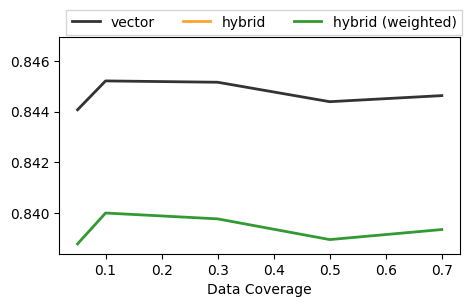

In [63]:
figure_size = (4.8, 2.7)

mean_2dlist, std_2dlist = parse_df_cv(df, metric='distances')

# make a line plot. x-axis: cv, y-axis: mean_acc
xs = np.array(cvs)
plot_data = get_plot_data(mean_2dlist, std_2dlist)

plot_cv_metric(xs, plot_data, figure_size, ylabel=ylabel, legend_loc='center left', minmax_line=False)
plt.ylabel(None);

In [64]:
# plot_data
xs

array([0.05, 0.1 , 0.3 , 0.5 , 0.7 ])

In [65]:
res_root = "../data/results/"
res_dir_dict = get_sort_resdir_by_name(res_root)

res_dirs = []
for k, v in res_dir_dict.items():
    for gk, res_dir in v.items():
        res_dirs.append(res_dir)

res_dirs

['../data/results/k5_gk3_outputs/stats_cos.res',
 '../data/results/k10_gk3_outputs/stats_cos.res',
 '../data/results/k10_gk5_outputs/stats_cos.res',
 '../data/results/k10_gk7_outputs/stats_cos.res',
 '../data/results/k50_gk5_outputs/stats_cos.res',
 '../data/results/k50_gk15_outputs/stats_cos.res',
 '../data/results/k50_gk25_outputs/stats_cos.res',
 '../data/results/k50_gk35_outputs/stats_cos.res',
 '../data/results/k100_gk10_outputs/stats_cos.res',
 '../data/results/k100_gk30_outputs/stats_cos.res',
 '../data/results/k100_gk50_outputs/stats_cos.res',
 '../data/results/k100_gk70_outputs/stats_cos.res',
 '../data/results/k500_gk50_outputs/stats_cos.res',
 '../data/results/k500_gk150_outputs/stats_cos.res',
 '../data/results/k500_gk250_outputs/stats_cos.res',
 '../data/results/k500_gk350_outputs/stats_cos.res',
 '../data/results/k1000_gk100_outputs/stats_cos.res',
 '../data/results/k1000_gk300_outputs/stats_cos.res',
 '../data/results/k1000_gk500_outputs/stats_cos.res',
 '../data/results

../data/results/k5_gk3_outputs/stats_cos.res
k5_gk3_outputs_dc


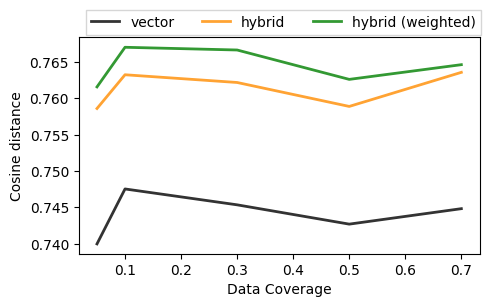

../data/results/k10_gk3_outputs/stats_cos.res
k10_gk3_outputs_dc


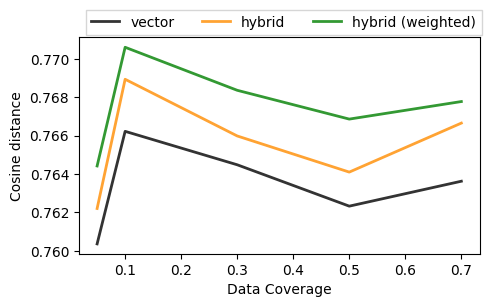

../data/results/k10_gk5_outputs/stats_cos.res
k10_gk5_outputs_dc


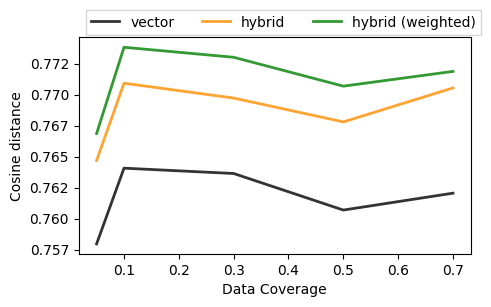

../data/results/k10_gk7_outputs/stats_cos.res
k10_gk7_outputs_dc


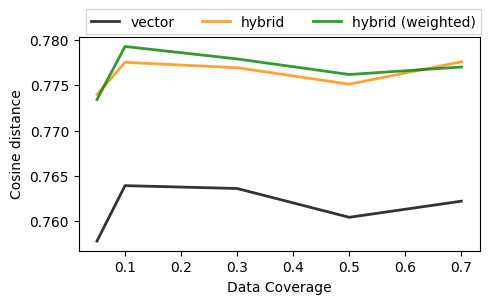

../data/results/k50_gk5_outputs/stats_cos.res
k50_gk5_outputs_dc


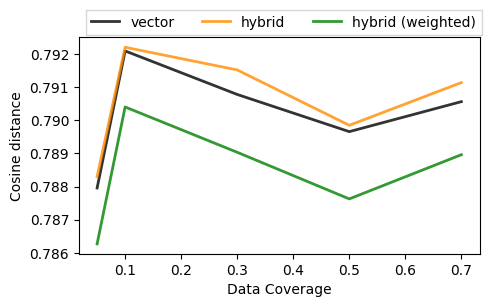

../data/results/k50_gk15_outputs/stats_cos.res
k50_gk15_outputs_dc


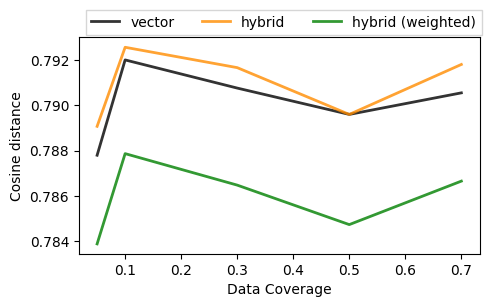

../data/results/k50_gk25_outputs/stats_cos.res
k50_gk25_outputs_dc


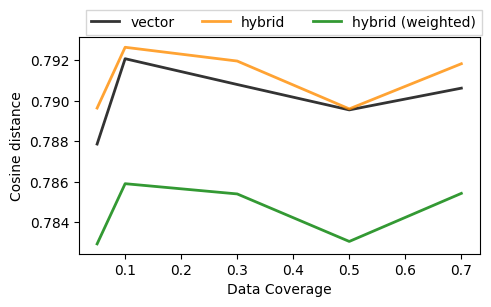

../data/results/k50_gk35_outputs/stats_cos.res
k50_gk35_outputs_dc


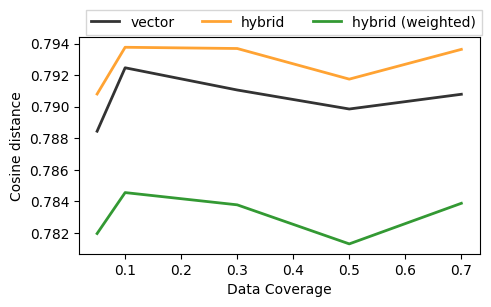

../data/results/k100_gk10_outputs/stats_cos.res
k100_gk10_outputs_dc


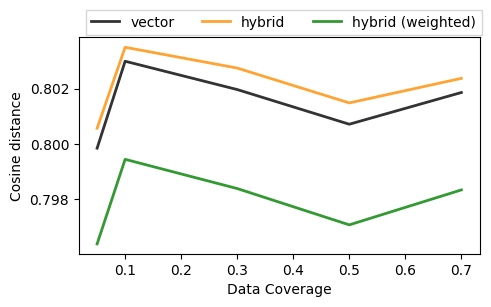

../data/results/k100_gk30_outputs/stats_cos.res
k100_gk30_outputs_dc


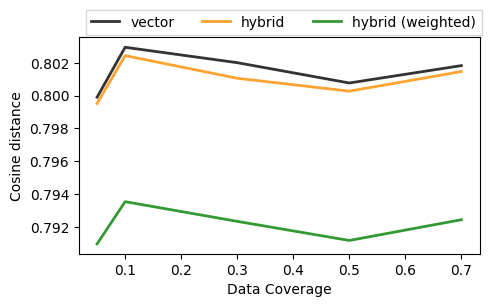

../data/results/k100_gk50_outputs/stats_cos.res
k100_gk50_outputs_dc


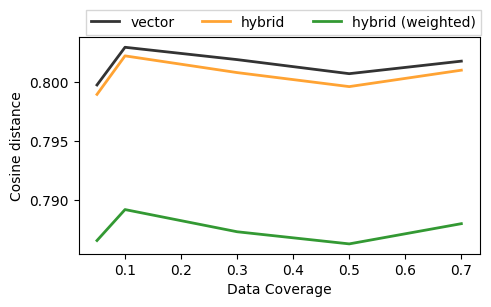

../data/results/k100_gk70_outputs/stats_cos.res
k100_gk70_outputs_dc


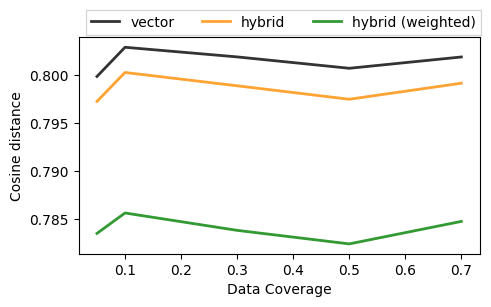

../data/results/k500_gk50_outputs/stats_cos.res
k500_gk50_outputs_dc


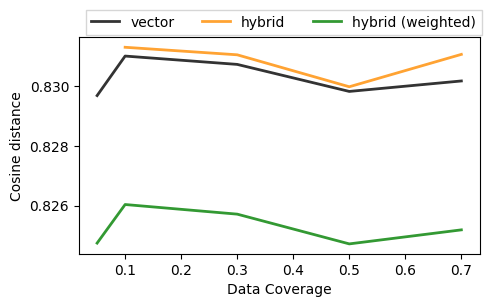

../data/results/k500_gk150_outputs/stats_cos.res
k500_gk150_outputs_dc


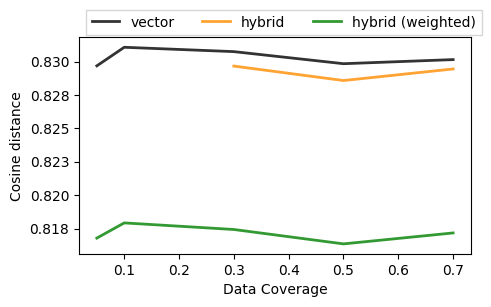

../data/results/k500_gk250_outputs/stats_cos.res
k500_gk250_outputs_dc


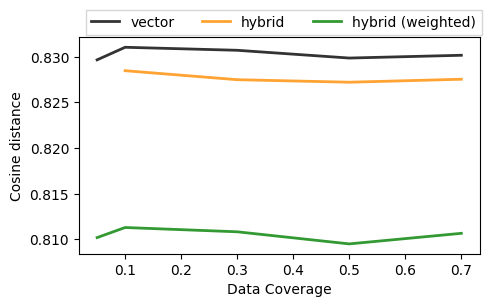

../data/results/k500_gk350_outputs/stats_cos.res
k500_gk350_outputs_dc


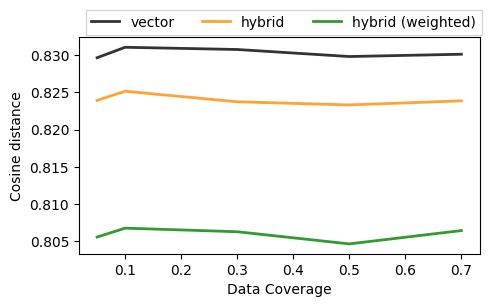

../data/results/k1000_gk100_outputs/stats_cos.res
k1000_gk100_outputs_dc


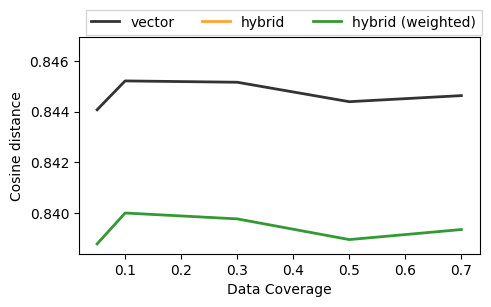

../data/results/k1000_gk300_outputs/stats_cos.res
k1000_gk300_outputs_dc


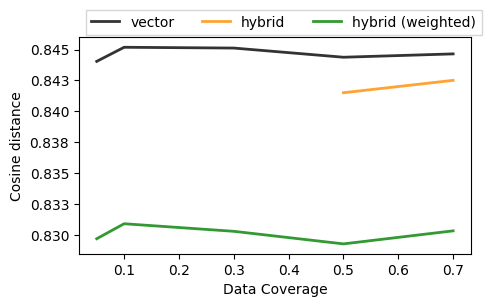

../data/results/k1000_gk500_outputs/stats_cos.res
k1000_gk500_outputs_dc


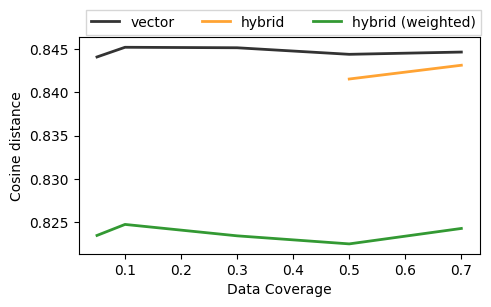

../data/results/k1000_gk700_outputs/stats_cos.res
k1000_gk700_outputs_dc


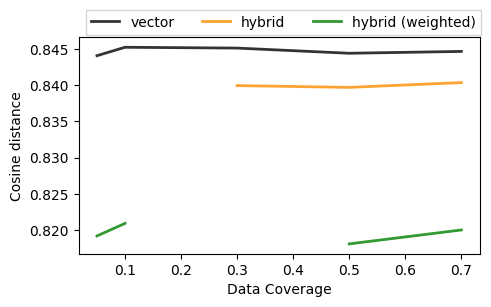

In [67]:
figure_size = (4.8, 2.7)
xs = np.array(cvs)

for df_path in res_dirs:
    print(df_path)
    if not os.path.exists(df_path):
        print("not exist!")
        continue
    df = pd.read_csv(df_path)
    df = preprocess_df(df)
    mean_2dlist, std_2dlist = parse_df_cv(df, metric='distances')
    plot_data = get_plot_data(mean_2dlist, std_2dlist)
    plot_cv_metric(xs, plot_data, figure_size, ylabel=ylabel, legend_loc='center left', minmax_line=False)
    # plt.tight_layout()

    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    fig_name = df_path.split('/')[-2] + "_dc"
    print(fig_name)
    # plt.savefig("plots/data_cv/{}.pdf".format(fig_name), bbox_inches='tight')
    # plt.ylabel(None);
    # plt.savefig("plots/data_cv/{}_no_ylabel.pdf".format(fig_name), bbox_inches='tight')
    plt.show()

## [1 workloads] Paper coverage vs. acc mean

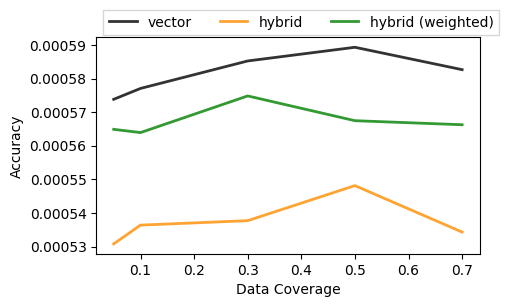

In [13]:
mean_2dlist, std_2dlist = parse_df_cv(df, metric='accuracy')

# make a line plot. x-axis: cv, y-axis: mean_acc
xs = np.array(cvs)
plot_cv_metric(xs, get_plot_data(mean_2dlist, std_2dlist), figure_size, ylabel="Accuracy", legend_loc='center left')

## [1 workloads] Paper coverage vs. include mean

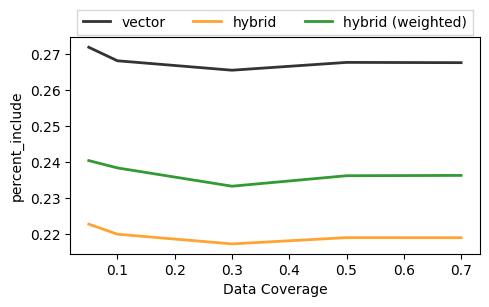

In [14]:
mean_2dlist, std_2dlist = parse_df_cv(df, metric='percent_include')

# make a line plot. x-axis: cv, y-axis: mean_acc
xs = np.array(cvs)
plot_cv_metric(xs, get_plot_data(mean_2dlist, std_2dlist), figure_size, ylabel="percent_include", legend_loc='center left')
plt.show()

## [1 workload] Abs prob vs. distance mean

In [15]:
def parse_df_prob(df, metric='distances'):
    mean_2dlist = {}
    std_2dlist = {}
    probs = np.unique(df['prob'])
    for p in probs:
        df_cv = df[df['prob'] == p]
        mergre_metric_dict = {}
        mergre_metric_std_dict = {}
        for index, row in df_cv.iterrows():
            stats_row_dict, stats_row_std_dict = get_methods_metrcs(row.to_dict(), metric=metric)
            if not mergre_metric_dict:
                mergre_metric_dict = stats_row_dict
            else:
                mergre_metric_dict = merge_metric_dict(mergre_metric_dict, stats_row_dict)
            
            if not mergre_metric_std_dict:
                mergre_metric_std_dict = stats_row_std_dict
            else:
                mergre_metric_std_dict = merge_metric_dict(mergre_metric_std_dict, stats_row_std_dict)

        mean_2dlist[p] = mergre_metric_dict
        std_2dlist[p] = mergre_metric_std_dict
    return mean_2dlist, std_2dlist

def get_plot_data_prob(mean_2dlist, std_2dlist):
    plot_data = {} # method: {mean, std}
    for x in sorted(list(mean_2dlist.keys())):
        # loop through each method
        for k, v in mean_2dlist[x].items():
            mean_data = []
            std_data = []
            max_data = []
            min_data = []
            mean_data.append(np.mean(v))
            max_data.append(np.max(v))
            min_data.append(np.min(v))
            # all_data = []
            # all_data.append(v)

            std_key = k.replace("mean", "std")
            std_data.append(np.mean(std_2dlist[x][std_key]))
            
            if k not in plot_data:
                plot_data[k] = {}
                plot_data[k]['mean'] = mean_data
                plot_data[k]['max'] = max_data
                plot_data[k]['min'] = min_data
                plot_data[k]['std'] = std_data
                plot_data[k]['all'] = [v]
            else:
                plot_data[k]['mean'] += mean_data
                plot_data[k]['max'] += max_data
                plot_data[k]['min'] += min_data
                plot_data[k]['std'] += std_data
                plot_data[k]['all'].append(v)
    return plot_data

def plot_prob_metric(xs, plot_data, figure_size, ylabel, xlabel="Probability of detail augmentation", legend_loc='center left', minmax_line=True):
    plt.figure(figsize=figure_size)
    for m, vd in plot_data.items():
        mean_data = vd['mean']
        max_data = vd['max']
        min_data = vd['min']
        all_data = vd['all']
        mlabel = select_plot_label(m)
    
        plt.plot(xs, mean_data, label=mlabel, color = select_color(m), alpha=0.8, linewidth=2)
        
        # print(xs, np.array(all_data).shape)
        # for one_xs, dp in zip(xs, all_data):
        #     plt.scatter([one_xs]*len(dp), dp, color = select_color(m), alpha=0.8, marker='.', s=1)

        # plt.fill_between(xs, min_data, max_data, color=select_color(m), alpha=0.2)
            
        # plot min and max as dashed lines
        if minmax_line:
            plt.plot(xs, min_data, label=None, color = select_color(m), linestyle='--', alpha=0.5, linewidth=2)
            plt.plot(xs, max_data, label=None, color = select_color(m), linestyle='--', alpha=0.5, linewidth=2)
    # plt.ylim([1.22, 1.24])
    plt.yscale('linear')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # plt.tight_layout()
    # make legend outside the plot and horizontally centered (like a title), as a row
    # plt.legend(loc=legend_loc, ncol=1, fancybox=False, shadow=False, bbox_to_anchor=(-0.5, 1.07))
    plt.legend(loc=legend_loc, ncol=1)

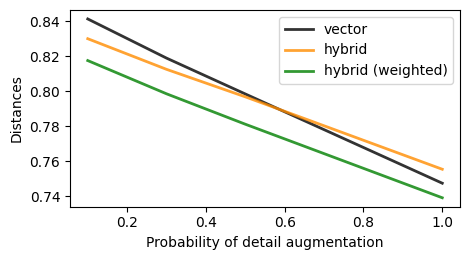

In [31]:
test_df = "../data/results/k100_gk70_outputs/stats_cos.res"
df = pd.read_csv(test_df)
df = preprocess_df(df)

mean_2dlist, std_2dlist = parse_df_prob(df, metric='distances')

# pprint(mean_2dlist.keys())

plot_data = get_plot_data_prob(mean_2dlist, std_2dlist)
plot_prob_metric(np.array(list(mean_2dlist.keys())), plot_data, figure_size, ylabel="Distances", legend_loc='best', minmax_line=False)

mean_2dlist[0.1].keys()

tmpk = "distances_arxiv_vector_mean"

# for 

In [17]:
def merge_extendl_dict(a, b):
    '''
    This function merges two dictionaries by extend list of values for same key
    '''
    merge_dict = {}
    for key in set(a) | set(b):
        if a.get(key, 0)!=0 and b.get(key, 0)!=0:
            merge_dict[key] = a[key] + b[key]
    return merge_dict

def merge_mean_2dlist(m1, m2):
    # m1: {prob: {method: [mean1, mean2, ...]}}
    # m2: {prob: {method: [mean3, mean4, ...]}}
    # return {prob: {method: [mean1, mean2, mean3, mean4, ...]}}
    res = {}
    for prob, m1_vals in m1.items():
        m2_vals = m2[prob]
        res[prob] = merge_extendl_dict(m1_vals, m2_vals)
    return res

In [18]:
# a = {1: [1], 3: [3]}
# b = {1: [2], 3: [3]}
# merge_extendl_dict(a, b)

In [19]:
mean_2dlist, std_2dlist = None, None
for k, v in res_dir_dict.items(): 
    if k in [5, 10]: continue
    for k2, v2 in v.items():
        # print(k, k2, v2)
        df = pd.read_csv(v2)
        df = preprocess_df(df)
        mean_2dlist2, std_2dlist2 = parse_df_prob(df, metric='distances')
        if mean_2dlist is None:
            mean_2dlist = mean_2dlist2.copy()
            std_2dlist = std_2dlist2.copy()
        else:
            mean_2dlist = merge_mean_2dlist(mean_2dlist, mean_2dlist2)
            std_2dlist = merge_mean_2dlist(std_2dlist, std_2dlist2)

In [20]:
# mean_2dlist[0.1]['distances_arxiv_vector_mean']
plot_data = get_plot_data_prob(mean_2dlist, std_2dlist)
# plot_data['distances_arxiv_vector_mean']

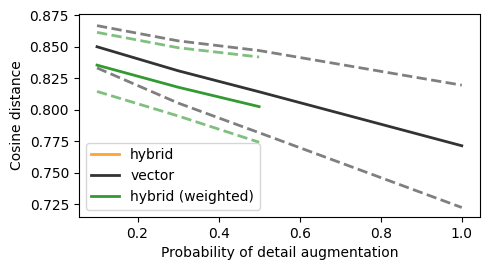

In [21]:
plot_data = get_plot_data_prob(mean_2dlist, std_2dlist)
plot_prob_metric(np.array(list(mean_2dlist.keys())), plot_data, (5, 2.8), ylabel=ylabel, legend_loc='best', minmax_line=True)

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# plt.savefig("plots/dist_vs_prob.pdf", bbox_inches='tight')
plt.show()

In [22]:
# plot_data
figure_size

(4.8, 2.7)

## [Multiple workloads with same k] gk vs. performance

In [25]:
k_gk_dict = get_sort_resdir_by_name(res_root, append_n="stats_cos.res")
pprint(k_gk_dict)

{5: {3: '../data/results/k5_gk3_outputs/stats_cos.res'},
 10: {3: '../data/results/k10_gk3_outputs/stats_cos.res',
      5: '../data/results/k10_gk5_outputs/stats_cos.res',
      7: '../data/results/k10_gk7_outputs/stats_cos.res'},
 50: {5: '../data/results/k50_gk5_outputs/stats_cos.res',
      15: '../data/results/k50_gk15_outputs/stats_cos.res',
      25: '../data/results/k50_gk25_outputs/stats_cos.res',
      35: '../data/results/k50_gk35_outputs/stats_cos.res'},
 100: {10: '../data/results/k100_gk10_outputs/stats_cos.res',
       30: '../data/results/k100_gk30_outputs/stats_cos.res',
       50: '../data/results/k100_gk50_outputs/stats_cos.res',
       70: '../data/results/k100_gk70_outputs/stats_cos.res'},
 500: {50: '../data/results/k500_gk50_outputs/stats_cos.res',
       150: '../data/results/k500_gk150_outputs/stats_cos.res',
       250: '../data/results/k500_gk250_outputs/stats_cos.res',
       350: '../data/results/k500_gk350_outputs/stats_cos.res'},
 1000: {100: '../data/res

0 50 5 ../data/results/k50_gk5_outputs/stats_cos.res
1 50 15 ../data/results/k50_gk15_outputs/stats_cos.res
2 50 25 ../data/results/k50_gk25_outputs/stats_cos.res
3 50 35 ../data/results/k50_gk35_outputs/stats_cos.res


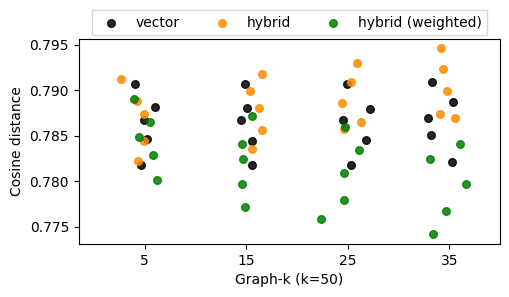

0 100 10 ../data/results/k100_gk10_outputs/stats_cos.res
1 100 30 ../data/results/k100_gk30_outputs/stats_cos.res
2 100 50 ../data/results/k100_gk50_outputs/stats_cos.res
3 100 70 ../data/results/k100_gk70_outputs/stats_cos.res


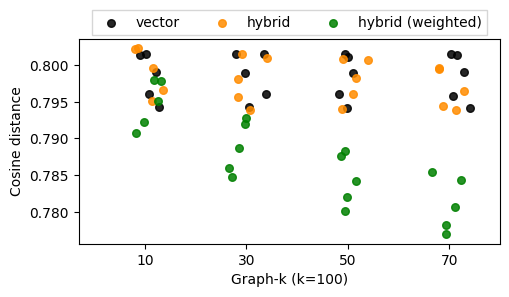

0 500 50 ../data/results/k500_gk50_outputs/stats_cos.res
1 500 150 ../data/results/k500_gk150_outputs/stats_cos.res
2 500 250 ../data/results/k500_gk250_outputs/stats_cos.res
3 500 350 ../data/results/k500_gk350_outputs/stats_cos.res


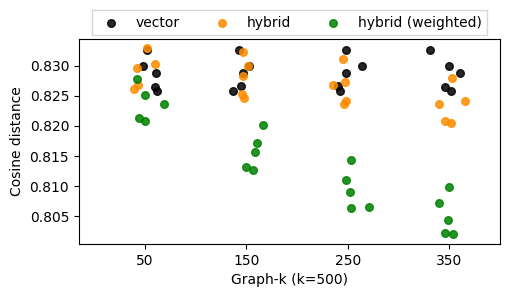

0 1000 100 ../data/results/k1000_gk100_outputs/stats_cos.res
1 1000 300 ../data/results/k1000_gk300_outputs/stats_cos.res
2 1000 500 ../data/results/k1000_gk500_outputs/stats_cos.res
3 1000 700 ../data/results/k1000_gk700_outputs/stats_cos.res


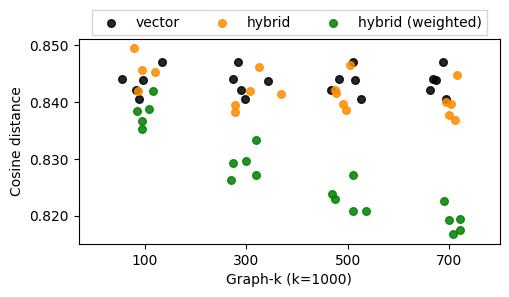

In [68]:
alpha = 0.85
s = 30
marker='o'
jitter_x = 0.1

for k, gk_fp in k_gk_dict.items(): 
    if k in [5, 10]: continue
    x_ticks = []
    plt.figure(figsize=(5.2, 3.1))
    for i, (gk, fp) in enumerate( gk_fp.items() ):
        print(i, k, gk, fp)
        x_ticks.append(str(gk))
        df = pd.read_csv(fp)
        df = preprocess_df(df)
        df = df[df['prob'] == 0.5]
        for method in ['arxiv_vector', 'hybrid', 'weighted_hybrid']:
            # print(method)
            col_name = "distances_{}_mean".format(method)
            data = df[col_name].values
            xs = np.random.normal(i+1, jitter_x, len(data))
            if i == 0:
                plt.scatter(xs, data, color=select_color(method), alpha=alpha, marker=marker, s=s, label=select_plot_label(method))
            else:
                plt.scatter(xs, data, color=select_color(method), alpha=alpha, marker=marker, s=s)
            # break
            
    # print()
    # set x xticks
    plt.xticks(np.arange(1, len(x_ticks)+1), x_ticks)
    plt.ylabel(ylabel)
    plt.xlim(0.35, 4.5)
    plt.xlabel("Graph-k (k={})".format(k))
    plt.legend(loc='center', ncol=3, fancybox=False, shadow=False, bbox_to_anchor=(0.5, 1.08))
    # plt.tight_layout()
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    # plt.savefig("plots/gk/k{}.pdf".format(k), bbox_inches='tight')
    # plt.ylabel(None);
    # plt.savefig("plots/gk/k{}_no_ylabel.pdf".format(k), bbox_inches='tight')
    plt.show()
    # break

## [Multiple workloads] k vs. performance

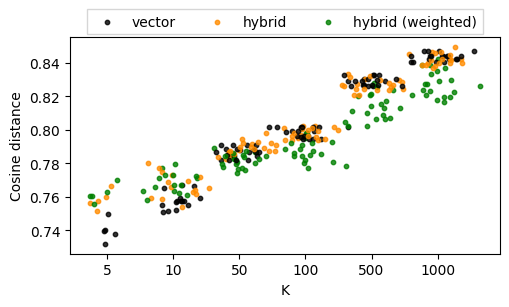

In [69]:
# pprint(k_gk_dict)

alpha = 0.8
s = 10
marker='o'
jitter_x = 0.23

plt.figure(figsize=(5.2, 3.2))

x_ticks = []
for i, (k, gk_fp) in enumerate( k_gk_dict.items() ):
    x_ticks.append(str(k))
    for gk, fp in gk_fp.items():
        # print(fp)
        df = pd.read_csv(fp)
        df = preprocess_df(df)
        df = df[df['prob'] == 0.5]
        for method in ['arxiv_vector', 'hybrid', 'weighted_hybrid']:
            # print(method)
            col_name = "distances_{}_mean".format(method)
            data = df[col_name].values
            xs = np.random.normal(i+1, jitter_x, len(data))
            if i == 0:
                plt.scatter(xs, data, color=select_color(method), alpha=alpha, marker=marker, s=s, label=select_plot_label(method))
            else:
                plt.scatter(xs, data, color=select_color(method), alpha=alpha, marker=marker, s=s)
    # print()

plt.xticks(np.arange(1, len(x_ticks)+1), x_ticks)
plt.ylabel(ylabel)
plt.xlabel("K")
plt.legend(loc='center', ncol=3, fancybox=False, shadow=False, bbox_to_anchor=(0.5, 1.07))
# plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.savefig("plots/dist_vs_k.pdf", bbox_inches='tight')
plt.show()

## Zoom in to k=1000, distances vs. kth data points

In [28]:
import ast
from scipy.spatial.distance import cosine as cosine_similarity

sys.path.append("../zy_testing")
from compute_metrics import *

def get_ids_embed_dict(db_res_obj):
    ids_embed_dict = {}
    for i, (id, embed) in enumerate(zip(db_res_obj['ids'], db_res_obj['embeddings'])):
        ids_embed_dict[str(id)] = embed
    return ids_embed_dict

def stack_embed_inorder(res_id_list, ids_embed_dict, fill=True, verbose=False):
    embed_list = []
    for i, id in enumerate(res_id_list):
        id = str(id)
        if id not in ids_embed_dict:
            if verbose: print(i, id)
            if fill:
                id = res_id_list[i-1]
            else:
                return False
        embed_list.append(ids_embed_dict[id])
    return np.array(embed_list)

def compute_distance_metrics_full(gt, pred, abstract_collection, dis_metric=""):
    gt_results = abstract_collection.get(ids=gt, include=["embeddings"])
    pred_results = abstract_collection.get(ids=pred, include=["embeddings"])
    # gt_results = np.array(gt_results["embeddings"])
    # pred_results = np.array(pred_results["embeddings"])
    # print(gt_results.shape)
    # gt_results = gt_results[: pred_results.shape[0], :]
    # print(gt_results.shape)
    gt_id_embed_dict = get_ids_embed_dict(gt_results)
    pred_id_embed_dict = get_ids_embed_dict(pred_results)
    gt_results = stack_embed_inorder(gt, gt_id_embed_dict)
    pred_results = stack_embed_inorder(pred, pred_id_embed_dict)

    if gt_results is False:
        print("size mismatch for gt")
        return -1, -1

    if pred_results is False:
        print("size mismatch for pred")
        return -1, -1

    if dis_metric == "cosine":
        # cosine similarity
        # distances = np.dot(gt_results, pred_results.T)
        # get mean for individual distances
        # indv_distance = np.mean(distances, axis=1)
        distances = [cosine_similarity(g, p) for g, p in zip(gt_results, pred_results)]
        indv_distance = distances
    else:
        # L2 distance
        distances = np.linalg.norm((gt_results - pred_results), axis=1)
        indv_distance = distances
    return np.mean(distances), indv_distance

def batch_compute_distance_metrics_full(gt_list, pred_list, abstract_collection, dis_metric=""):
    """
    Compute the percentage of ground truth that is included in the prediction for a batch of data, return a list of percentages
    """
    mean_dists = []
    indv_dists = []
    for i, (gt, pred) in enumerate(zip(gt_list, pred_list)):
        if len(gt) != len(pred):
            print("size mismatch, add cuur mean to the list")
            mean_dists.append(np.mean(mean_dists))
            continue
        mean_dist, indv_dist = compute_distance_metrics_full(gt, pred, abstract_collection, dis_metric=dis_metric)
        if mean_dist == -1:
            print(i, "size mismatch, skip")
            continue
        mean_dists.append(mean_dist)
        indv_dists.append(indv_dist)
    return mean_dists, indv_dists

In [29]:
client = chromadb.PersistentClient(path="../data/chroma_dbs/")
abstract_collection = client.get_collection(name="abs_arxiv_vector")
abstract_collection.count()

12902

In [30]:
def plot_dist_k(k, gk, abstract_collection, sample_size=100, dis_metric="cosine"):
    res_path = "../data/results/k{}_gk{}_outputs/k{}_gk{}_cv0_3_num5_prob0_5.csv".format(k, gk, k, gk)
    df = pd.read_csv(res_path)
    sample_df = df.sample(sample_size)
    gt_output_list = sample_df['abs_arxiv_vector'].apply(ast.literal_eval).tolist()
    vec_output_list = sample_df['arxiv_vector'].apply(ast.literal_eval).tolist()
    hy_output_list = sample_df['hybrid'].apply(ast.literal_eval).tolist()
    hy_weighted_output_list = sample_df['weighted_hybrid'].apply(ast.literal_eval).tolist()

    print("vec")
    vec_mean_dist, vec_dists =  batch_compute_distance_metrics_full(gt_output_list, vec_output_list, abstract_collection, dis_metric=dis_metric)
    print("hy")
    hy_mean_dist, hy_dists =  batch_compute_distance_metrics_full(gt_output_list, hy_output_list, abstract_collection, dis_metric=dis_metric)
    print("hyw")
    hyw_mean_dist, hyw_dists =  batch_compute_distance_metrics_full(gt_output_list, hy_weighted_output_list, abstract_collection, dis_metric=dis_metric)

    s = 3
    marker='o'
    vec_dists_mean = np.mean(vec_dists, axis=0)
    
    start_from = len(vec_dists_mean) - gk
    hyw_dists_mean = np.mean(hyw_dists, axis=0)[start_from:]
    hy_dists_mean = np.mean(hy_dists, axis=0)[start_from:]

    plt.figure(figsize=(6.1, 3))
    # plt.plot(np.arange(1, len(dists)+1), dists, color='black', alpha=0.8)
    plt.scatter(np.arange(1, len(vec_dists_mean)+1), vec_dists_mean, color=select_color('vector'), alpha=0.6, marker=marker, s=s, label=select_plot_label('vector'))
    plt.scatter(np.arange(1, len(hy_dists_mean)+1)+start_from, hy_dists_mean, color=select_color('hybrid'), alpha=0.6, marker=marker, s=s, label=select_plot_label('hybrid'))
    plt.scatter(np.arange(1, len(hyw_dists_mean)+1)+start_from, hyw_dists_mean, color=select_color('hybrid (weighted)'), alpha=0.75, marker=marker, s=s, label=select_plot_label('hybrid (weighted)'))
    # plt.ylim([1.1, 1.4])

    # add vertical dashed lines
    plt.axvline(x=start_from, color='black', linestyle='--', alpha=1)
    # create xticks (step size = 100), and if start_from is not in the list, add it
    xticks = list(np.arange(0, len(vec_dists_mean)+1, 100))
    if start_from not in xticks:
        xticks.append(start_from)
    # sort xticks
    xticks = sorted(xticks)
    plt.xticks(xticks, xticks)

    plt.ylabel(ylabel)
    plt.xlabel("Kth data points")
    plt.legend(loc='center', ncol=3, fancybox=False, shadow=False, bbox_to_anchor=(0.5, 1.08))

vec
hy
hyw


(0.5, 1.01)

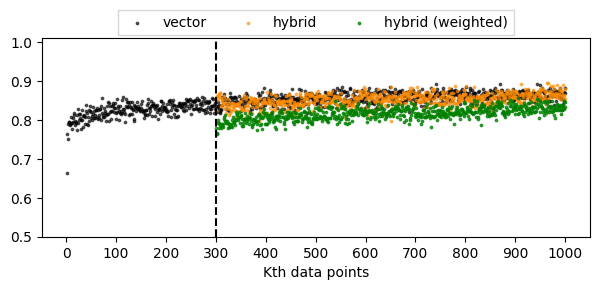

In [94]:
plot_dist_k(k=1000, gk=700, abstract_collection=abstract_collection, sample_size=100, dis_metric="cosine")
plt.ylabel(None);
plt.ylim([0.5, 1.01])

In [98]:
db_res_obj = {}
db_res_obj['ids'] = [1, 2, 3, 4]
db_res_obj['embeddings']=  [1, 2, 3, 4, 5]

for i, (id, embed) in enumerate(zip(db_res_obj['ids'], db_res_obj['embeddings'])):
    print(id, embed)

1 1
2 2
3 3
4 4


### k1000

In [22]:
# sample_size = 100
# plot_dist_k(k=1000, gk=100, abstract_collection=abstract_collection, sample_size=sample_size)
# # plt.tight_layout()
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.savefig("plots/zoom/k1000gk100.pdf", bbox_inches='tight')
# plt.ylabel(None);
# plt.savefig("plots/zoom/k1000gk100_no_ylabel.pdf", bbox_inches='tight')
# plt.show()

# plot_dist_k(k=1000, gk=300, abstract_collection=abstract_collection, sample_size=sample_size)
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.savefig("plots/zoom/k1000gk300.pdf", bbox_inches='tight')
# plt.ylabel(None);
# plt.savefig("plots/zoom/k1000gk300_no_ylabel.pdf", bbox_inches='tight')
# plt.show()

# plot_dist_k(k=1000, gk=500, abstract_collection=abstract_collection, sample_size=sample_size)
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.savefig("plots/zoom/k1000gk500.pdf", bbox_inches='tight')
# plt.ylabel(None);
# plt.savefig("plots/zoom/k1000gk500_no_ylabel.pdf", bbox_inches='tight')
# plt.show()

# plot_dist_k(k=1000, gk=700, abstract_collection=abstract_collection, sample_size=sample_size)
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.savefig("plots/zoom/k1000gk700.pdf", bbox_inches='tight')
# plt.ylabel(None);
# plt.savefig("plots/zoom/k1000gk700_no_ylabel.pdf", bbox_inches='tight')
# plt.show()

### k500

In [21]:
# sample_size = 100
# plot_dist_k(k=500, gk=50, abstract_collection=abstract_collection, sample_size=sample_size)
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.savefig("plots/zoom/k500gk50.pdf", bbox_inches='tight')
# plt.ylabel(None);
# plt.savefig("plots/zoom/k500gk50_no_ylabel.pdf", bbox_inches='tight')
# plt.show()

# plot_dist_k(k=500, gk=150, abstract_collection=abstract_collection, sample_size=sample_size)
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.savefig("plots/zoom/k500gk150.pdf", bbox_inches='tight')
# plt.ylabel(None);
# plt.savefig("plots/zoom/k500gk150_no_ylabel.pdf", bbox_inches='tight')
# plt.show()

# plot_dist_k(k=500, gk=250, abstract_collection=abstract_collection, sample_size=sample_size)
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.savefig("plots/zoom/k500gk250.pdf", bbox_inches='tight')
# plt.ylabel(None);
# plt.savefig("plots/zoom/k500gk250_no_ylabel.pdf", bbox_inches='tight')
# plt.show()

# plot_dist_k(k=500, gk=350, abstract_collection=abstract_collection, sample_size=sample_size)
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.savefig("plots/zoom/k500gk350.pdf", bbox_inches='tight')
# plt.ylabel(None);
# plt.savefig("plots/zoom/k500gk350_no_ylabel.pdf", bbox_inches='tight')
# plt.show()